In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
df = pd.read_csv('data/aviation_cleaned.csv', index_col=0)
df.shape

(88793, 22)

In [4]:
# dropping non-airplane rows
df = df[(df['aircraft_category'] == 'Airplane') | (df['aircraft_category'] == 'Unknown')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84140 entries, 0 to 88792
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                84140 non-null  object
 1   investigation_type      84140 non-null  object
 2   event_date              84140 non-null  object
 3   location                84140 non-null  object
 4   country                 84140 non-null  object
 5   injury_severity         84140 non-null  object
 6   aircraft_damage         84140 non-null  object
 7   aircraft_category       84140 non-null  object
 8   make                    84140 non-null  object
 9   model                   84140 non-null  object
 10  amateur_built           84140 non-null  object
 11  number_of_engines       84140 non-null  int64 
 12  engine_type             84140 non-null  object
 13  purpose_of_flight       84140 non-null  object
 14  air_carrier             84140 non-null  object
 15  to

In [7]:
# create 'year' column
df['year'] = df['event_date'].map(lambda x: int(x[:4]))

# only keep last 20 years of data
df = df[df['year'] >= 2003]
df.shape

(30700, 23)

# Condensing the large group of df['make'] (plane manufacturer)

In [168]:
# too many unique makes
(f'Total planes: {df.shape[0]}, Unique makes: {df["make"].nunique()}')

'Total planes: 30700, Unique makes: 4146'

In [252]:
# 4146 plane manufacturers is simply too many to analyze
# top 4 makes have over 1500 accidents recorded each in last 20 years
df['make'].value_counts().head(8)

Cessna         8723
Piper          4910
Beech          1853
Boeing         1548
Mooney          471
Air Tractor     287
Airbus          268
Bellanca        265
Name: make, dtype: int64

In [254]:
# find at what percent each make occurs in df
norm_counts = df['make'].value_counts(normalize=True).values
(f'Top 20 makes = {norm_counts[:20].sum() * 100:.2f}% of data')

'Top 20 makes = 67.33% of data'

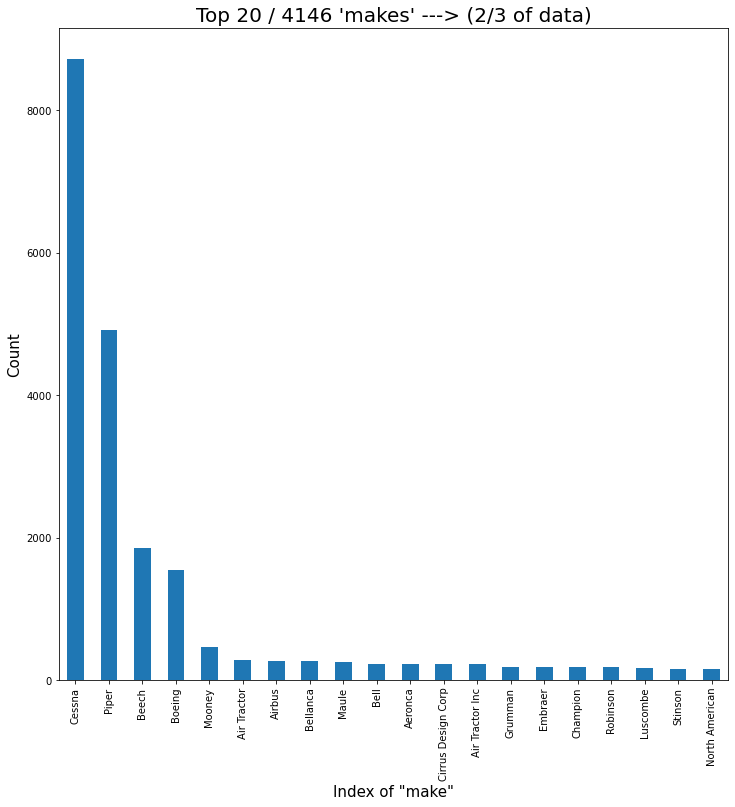

In [262]:
top_20_makes = df['make'].value_counts().head(20)

top_20_makes.plot(kind='bar', figsize=(12,12))

plt.title('Top 20 / 4146 \'makes\' ---> (2/3 of data)', fontsize=20)
plt.xlabel('Index of "make"', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

# Going from top 20 -> top 4 only goes from 67% -> 55% of data

In [263]:
top_4_index = df['make'].value_counts().index[:4]
top_4_values = df['make'].value_counts().values[:4]

(f'Top 4 makes = {norm_counts[:4].sum() * 100:.2f}% of data')

'Top 4 makes = 55.49% of data'

In [264]:
top_4_makes = df[df['make'].isin(top_4_index)]
top_4_makes

,event_id,investigation_type,event_date,location,country,injury_severity,aircraft_damage,aircraft_category,make,model,...,purpose_of_flight,air_carrier,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,weather_condition,broad_phase_of_flight,report_status,year
53915,20030107X00031,Accident,2003-01-01,"TUCSON, AZ",United States,Fatal(1),Destroyed,Unknown,Beech,95,...,Personal,Unknown,1,3,0,0,VMC,Takeoff,Probable Cause,2003
53921,20030123X00097,Accident,2003-01-03,"JESSUP, GA",United States,Non-Fatal,Substantial,Unknown,Cessna,150K,...,Personal,Unknown,0,0,0,1,VMC,Cruise,Probable Cause,2003
53922,20030109X00038,Accident,2003-01-03,"MC ALLEN, TX",United States,Non-Fatal,Substantial,Unknown,Cessna,401,...,Personal,Unknown,0,0,0,1,VMC,Cruise,Probable Cause,2003
53923,20030108X00036,Accident,2003-01-03,"ALTON, IL",United States,Non-Fatal,Substantial,Unknown,Cessna,182S,...,Instructional,Unknown,0,0,0,1,VMC,Takeoff,Probable Cause,2003
53925,20030110X00042,Accident,2003-01-03,"Santo Domingo, Dominican Republic",Dominican Republic,Fatal(1),Destroyed,Airplane,Beech,Be-60,...,Personal,Unknown,1,1,0,0,VMC,Unknown,Foreign,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88784,20221219106477,Accident,2022-12-18,"San Manual, AZ",United States,Non-Fatal,Unknown,Unknown,Piper,Pa28,...,Personal,Chandler Air Service,0,0,0,3,Unknown,Unknown,Unknown,2022
88785,20221221106483,Accident,2022-12-21,"Auburn Hills, MI",United States,Minor,Unknown,Unknown,Cessna,172F,...,Personal,Pilot,0,1,0,0,Unknown,Unknown,Unknown,2022
88788,20221227106491,Accident,2022-12-26,"Annapolis, MD",United States,Minor,Unknown,Unknown,Piper,Pa-28-151,...,Personal,Unknown,0,1,0,0,Unknown,Unknown,Unknown,2022
88791,20221227106498,Accident,2022-12-26,"Morgan, UT",United States,Unknown,Unknown,Unknown,Cessna,210N,...,Personal,MC CESSNA 210N LLC,0,0,0,0,Unknown,Unknown,Unknown,2022


# Investigating the safety of these top 4 makes
- avg injury severity
- avg [fatal, serious, minor]

In [292]:
# get counts for each of the top 9 makes
make_counts = df['make'].value_counts()[:4].reset_index()
make_counts.columns = ['make', 'num_flights']
make_counts

,make,num_flights
0,Cessna,8723
1,Piper,4910
2,Beech,1853
3,Boeing,1548


In [298]:
# calculate average injuries for each unique plane
cols = ['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries', 'total_uninjured', 'number_of_engines']
makes_stats = top_4_makes.groupby('make')[cols].mean().reset_index()

# rename to 'avg'
makes_stats.columns = ['make', 'avg_fatal_injuries', 'avg_serious_injuries', 'avg_minor_injuries', 'avg_uninjured', 'avg_num_engines']

# merge with make_counts to add num_flights
makes_stats = makes_stats.merge(make_counts, on='make', how='left')

print('Average stats for top 4 makes:')
makes_stats

Average stats for top 4 makes:


,make,avg_fatal_injuries,avg_serious_injuries,avg_minor_injuries,avg_uninjured,avg_num_engines,num_flights
0,Beech,0.772,0.241,0.199,1.273,1.219,1853
1,Boeing,2.660,0.923,0.339,71.176,0.971,1548
2,Cessna,0.391,0.225,0.189,1.232,0.999,8723
3,Piper,0.450,0.207,0.185,1.106,1.053,4910


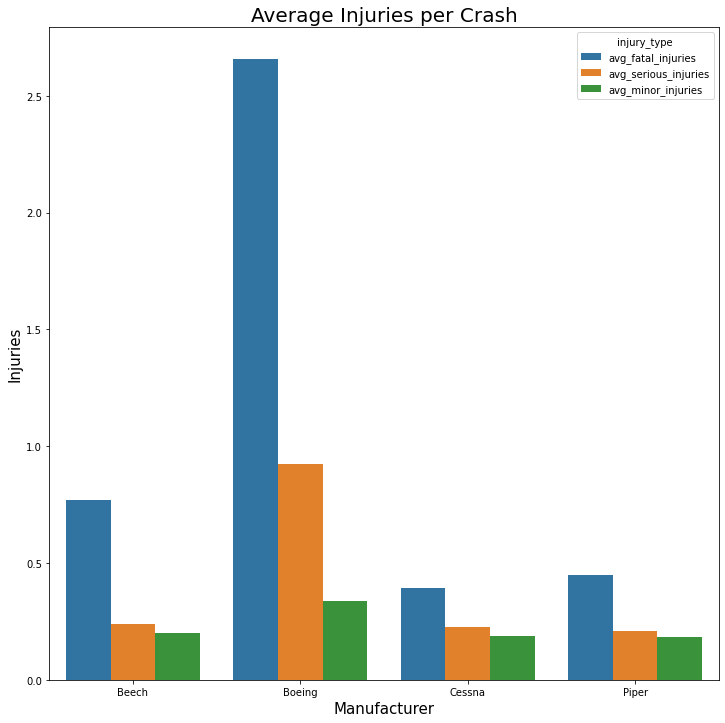

In [299]:
# reshape df to long format
df_long = makes_stats.melt(id_vars='make',
                  value_vars=['avg_fatal_injuries', 'avg_serious_injuries', 'avg_minor_injuries'],
                  var_name='injury_type',
                  value_name='average')


fig, ax =plt.subplots(figsize=(12,12))

sns.barplot(data=df_long, x='make', y='average', hue='injury_type', ax=ax)

ax.set_title('Average Injuries per Crash', fontsize=20)
ax.set_xlabel('Manufacturer', fontsize=15)
ax.set_ylabel('Injuries', fontsize=15);

### The above graphic does not take into account num_passengers per flight/accident

- Boeing has highest injury counts per accident but also has highest uninjured count (by far). This means boeing planes are predominantly large, commercial vessels.
- Cessna has lowest injury statistics per crash. Piper is close second.

# The 4 most recorded plane manufacturers (by far) in terms of accident reports are:

- Cessna
- Piper
- Beech
- Boeing

## Goal: Find top 10 safest models per make

# Question: How do we quantify "safety"? (without num_passengers)

- Using avg total_injury vals
- Low (avg_fatal or avg_serious) should up the 'safety score'. High values would lower the score.
- Opposite is true for (avg_minor or avg_uninjured)
- aircraft_damage is another factor

In [275]:
# new dataframe only holding 17k rows of top 4 makes
df_top_4 = df[df['make'].isin(['Cessna', 'Piper', 'Beech', 'Boeing'])]
df_top_4.shape

(17034, 23)

In [277]:
df_top_4['aircraft_damage'].unique()

array(['Destroyed', 'Substantial', 'Unknown', 'Minor'], dtype=object)

In [300]:
# function to get normalized aircraft_damage value counts for each make
def get_damage_distribution(make):
    df_clean = top_4_makes[top_4_makes['make'] == make]
    
    return df_clean['aircraft_damage'].value_counts(normalize=True)

damage_df = makes_stats['make'].apply(get_damage_distribution)

# adding 4 columns showing normalized count (percent) of each category of aircraft damage
makes_stats = pd.concat([makes_stats, damage_df], axis=1)
makes_stats.shape

(4, 11)

In [305]:
# cleaning up makes_stats
makes_stats = makes_stats[['make', 'num_flights', 'avg_fatal_injuries', 'avg_serious_injuries', 
                           'avg_minor_injuries', 'avg_uninjured', 'Destroyed', 'Substantial', 'Minor', 'Unknown']]
makes_stats

,make,num_flights,avg_fatal_injuries,avg_serious_injuries,avg_minor_injuries,avg_uninjured,Destroyed,Substantial,Minor,Unknown
0,Beech,1853,0.772,0.241,0.199,1.273,0.209,0.740,0.026,0.024
1,Boeing,1548,2.660,0.923,0.339,71.176,0.041,0.225,0.248,0.485
2,Cessna,8723,0.391,0.225,0.189,1.232,0.117,0.848,0.014,0.021
3,Piper,4910,0.450,0.207,0.185,1.106,0.136,0.836,0.013,0.015


# Observations
- Hard to judge the injury numbers without knowing avg_passenger_count. Would need to look at specific models for each make to gain this insight.

- 25% of Boeing accident were classified as "Minor". This is much higher than the 3 private makes. Would be interested at comparing this number to __other commercial (large) planes__.
- Beech has a 21% "Destroyed" rate AND a 74% "Substantial" rate. __Significantly worse than Cessna and Piper__.
- Cessna and Piper are very comparable accross the board.

# 3 categories of aircraft_damage:

- Minor
- Substantial
- Destroyed

In [236]:
df_cessna = df_top_4[df_top_4['make'] == 'Cessna']
df_piper = df_top_4[df_top_4['make'] == 'Piper']
df_beech = df_top_4[df_top_4['make'] == 'Beech']
df_boeing = df_top_4[df_top_4['make'] == 'Boeing']

for df, name in zip([df_cessna, df_piper, df_beech, df_boeing], ['Cessna', 'Piper', 'Beech', 'Boeing']):
    print(f'df_{name} shape: {df.shape}, Num of unique models: {df["model"].nunique()}')

df_Cessna shape: (8723, 23), Num of unique models: 451
df_Piper shape: (4910, 23), Num of unique models: 373
df_Beech shape: (1853, 23), Num of unique models: 272
df_Boeing shape: (1548, 23), Num of unique models: 311


In [214]:
df_top_4['aircraft_damage'].value_counts(normalize=True)

Substantial    0.776095
Destroyed      0.125572
Unknown        0.061994
Minor          0.036339
Name: aircraft_damage, dtype: float64

In [283]:
df_cessna['aircraft_damage'].value_counts(normalize=True).values

array([0.84764416, 0.11670297, 0.02143758, 0.01421529])

In [216]:
df_piper['aircraft_damage'].value_counts(normalize=True)

Substantial    0.836049
Destroyed      0.136253
Unknown        0.015071
Minor          0.012627
Name: aircraft_damage, dtype: float64

In [217]:
df_beech['aircraft_damage'].value_counts(normalize=True)

Substantial    0.740421
Destroyed      0.209390
Minor          0.026444
Unknown        0.023745
Name: aircraft_damage, dtype: float64

In [218]:
df_boeing['aircraft_damage'].value_counts(normalize=True)

Unknown        0.485142
Minor          0.248062
Substantial    0.225452
Destroyed      0.041344
Name: aircraft_damage, dtype: float64

In [238]:
df_cessna['model'].value_counts()

172            816
152            381
172S           327
182            318
172N           311
              ... 
T182 - T         1
U-206G           1
F177Rg           1
C175A            1
Skyhawk 172      1
Name: model, Length: 451, dtype: int64